In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, ttest_1samp


In [26]:
df = pd.read_csv("/mnt/hdd/anatkorol/Imagination_in_translation/Data/processed_data/08092025_pilot/participants_log_with_gpt_with_distances_and_alignment_and_len_pilot_08092025_.csv")
df = df[['uid', 'gt', 'session', 'attempt', 'prompt', 'gen', 'subjective_score','clip_cosine_distance', 'vgg_fc7_distance', 'prompt_word_len', 'token_num', 'clip_vis_text_similarity']].copy()
df_ppt = df[df['uid'] != 'gpt-5'].copy()
df_gpt = df[df['uid'] == 'gpt-5'].copy()

In [27]:
df.columns

Index(['uid', 'gt', 'session', 'attempt', 'prompt', 'gen', 'subjective_score',
       'clip_cosine_distance', 'vgg_fc7_distance', 'prompt_word_len',
       'token_num', 'clip_vis_text_similarity'],
      dtype='object')

In [28]:
pd.set_option('display.max_colwidth', None)
df['token_num'].max()


np.int64(219)

In [4]:

# Set style for academic presentation
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Visualizing legnth of prompt by attempt

/tmp/ipykernel_2537055/525857349.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df_ppt_mean, x="attempt", y="prompt_word_len", ci="sd", color="lightblue")


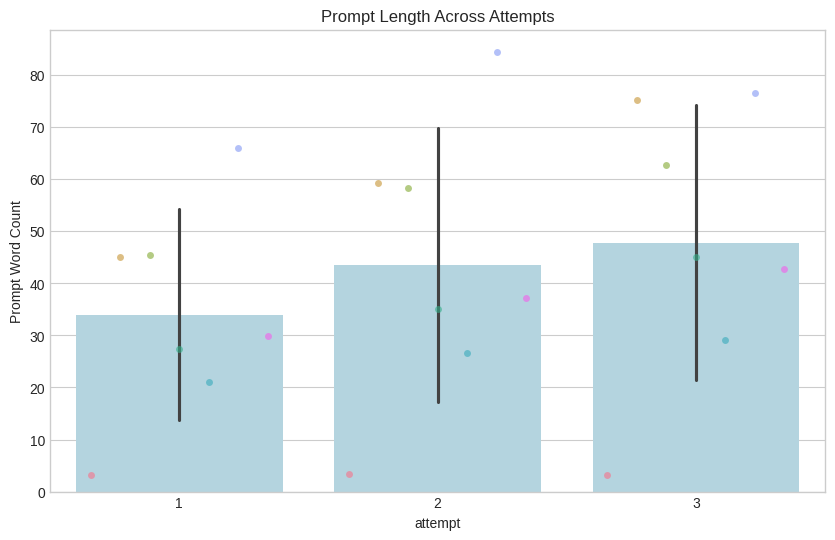

In [5]:
df_ppt_mean = df_ppt.groupby(["uid", "attempt"])["prompt_word_len"].mean().reset_index()
plt.figure(figsize=(10,6))
sns.barplot(data=df_ppt_mean, x="attempt", y="prompt_word_len", ci="sd", color="lightblue")
sns.stripplot(data=df_ppt_mean, x="attempt", y="prompt_word_len", hue="uid", alpha=0.6, jitter=True, dodge=True)
plt.ylabel("Prompt Word Count")
plt.title("Prompt Length Across Attempts")
plt.legend([],[], frameon=False)  #removing legend (info about ppt)
plt.show()

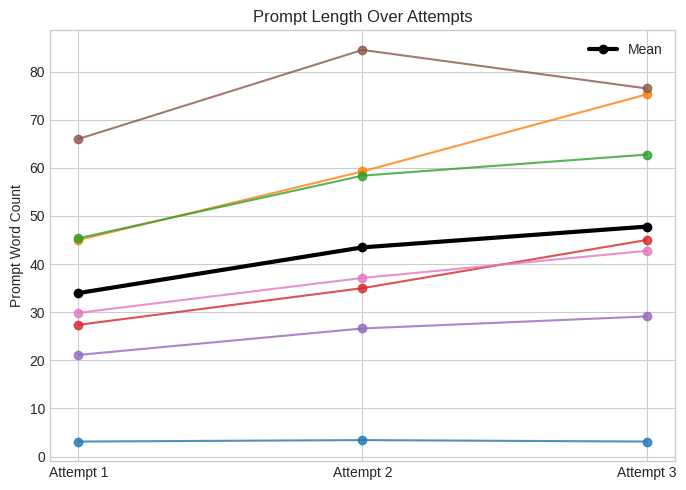

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set style for academic presentation
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

df_mean = df_ppt.groupby(["uid", "attempt"])["prompt_word_len"].mean().reset_index()
# Pivot to wide form
wide = df_mean.pivot(index="uid", columns="attempt", values="prompt_word_len")

plt.figure(figsize=(7,5))

# Pick a nice color palette (enough colors for all participants)
palette = sns.color_palette("tab10", n_colors=len(wide))

# Individual participant lines with unique colors
for (uid, row), color in zip(wide.iterrows(), palette):
    plt.plot([1,2,3], [row[1], row[2], row[3]], 
             marker="o", lw=1.5, alpha=0.8, color=color)

# Group mean in black
mean_vals = wide.mean()
plt.plot([1,2,3], mean_vals, marker="o", color="black", linewidth=3, label="Mean")

# Formatting
plt.xticks([1,2,3], ["Attempt 1", "Attempt 2", "Attempt 3"])
plt.ylabel("Prompt Word Count")
plt.title("Prompt Length Over Attempts")
plt.legend()
plt.tight_layout()
plt.show()


# Correlation between subjective and objective similarity scores 

In [9]:
# inverting cosine distance to similarity
df_ppt["clip_similarity"] = 1 - df_ppt["clip_cosine_distance"]
df_ppt['vgg_similarity'] = 1 - df_ppt['vgg_fc7_distance']
df_gpt["clip_similarity"] = 1 - df_gpt["clip_cosine_distance"]
df_gpt['vgg_similarity'] = 1 - df_gpt['vgg_fc7_distance']
df['clip_similarity'] = 1 - df['clip_cosine_distance']
df['vgg_similarity'] = 1 - df['vgg_fc7_distance']

## correlation between vgg and clip similarity

In [10]:
pearson_corr, pearson_p = pearsonr(df['clip_cosine_distance'], df['vgg_fc7_distance'])
print(f"Pearson correlation between CLIP and VGG distances: {pearson_corr:.3f} (p={pearson_p:.3f})")


Pearson correlation between CLIP and VGG distances: 0.173 (p=0.017)


## computing correlations between subjective and objective similarity scores - globally

In [11]:
#computing correlation as if all data points are independent - but they are not!!
pearson_corr, pearson_p = pearsonr(df_ppt["subjective_score"], df_ppt["clip_similarity"])
print(f"Pearson correlation between subjective score and CLIP similarity: {pearson_corr:.3f} (p={pearson_p:.3f})")

Pearson correlation between subjective score and CLIP similarity: 0.189 (p=0.014)


In [12]:
pearson_corr, pearson_p = pearsonr(df_ppt["subjective_score"], df_ppt["vgg_similarity"])
print(f"Pearson correlation between subjective score and VGG fc7 similarity: {pearson_corr:.3f} (p={pearson_p:.3f})")

Pearson correlation between subjective score and VGG fc7 similarity: 0.169 (p=0.029)


## computing correlations between subjective and objective similarity scores - within participants

/tmp/ipykernel_2537055/3114396826.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=df_corr, x="measure", y="r", ci=None, color="lightblue")


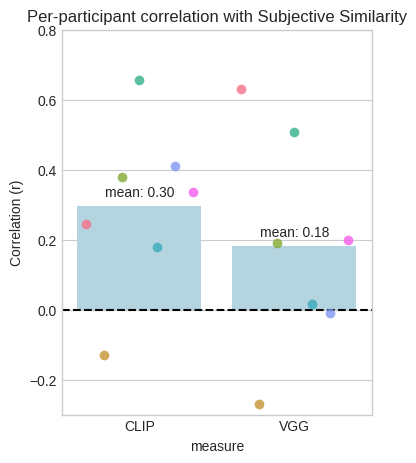

In [ ]:
# Collect correlations per participant
corrs = []
for uid, subdf in df_ppt.groupby("uid"):
    r_clip, _ = pearsonr(subdf["subjective_score"], subdf["clip_similarity"])
    r_vgg, _ = pearsonr(subdf["subjective_score"], subdf["vgg_similarity"])
    corrs.append({"uid": uid, "measure": "CLIP", "r": r_clip})
    corrs.append({"uid": uid, "measure": "VGG", "r": r_vgg})

df_corr = pd.DataFrame(corrs)

# Compute means
means = df_corr.groupby("measure")["r"].mean().reset_index()

plt.figure(figsize=(4,5))
ax = sns.barplot(data=df_corr, x="measure", y="r", ci=None, color="lightblue")

# Add participant dots
sns.stripplot(data=df_corr, x="measure", y="r", hue="uid",
              dodge=True, jitter=False, size=7, alpha=0.8)

# Add horizontal line at 0
plt.axhline(0, color="black", linestyle="--")

# Add mean value labels
for i, row in means.iterrows():
    ax.text(i, row["r"] + 0.02, f"mean: {row['r']:.2f}", 
            ha='center', va='bottom', fontsize=10)

plt.ylabel("Correlation (r)")
plt.title("Objective and Subjective similarity correlation  -  per paricipant")
plt.legend([],[], frameon=False)  # remove uid legend
plt.ylim(-0.3, 0.8)  # keep full r range visible
plt.show()


## measuring Mixed-effects regression 
* I don't understand it and I didn't report it for now*
* Treat subjective score as DV, and use clip/vgg similarity as predictors, with random intercepts for participants

In [100]:
import statsmodels.formula.api as smf

model = smf.mixedlm("subjective_score ~ vgg_similarity",
                    data=df_ppt, groups=df_ppt["uid"])
result = model.fit()
print(result.summary())


            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: subjective_score
No. Observations: 167     Method:             REML            
No. Groups:       7       Scale:              300.5667        
Min. group size:  23      Log-Likelihood:     -718.3776       
Max. group size:  24      Converged:          Yes             
Mean group size:  23.9                                        
---------------------------------------------------------------
                 Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept        29.996     9.064  3.309  0.001  12.232  47.760
vgg_similarity   30.097     9.258  3.251  0.001  11.953  48.242
Group Var       384.118    13.455                              



In [101]:
import statsmodels.formula.api as smf

model = smf.mixedlm("subjective_score ~ clip_similarity",
                    data=df_ppt, groups=df_ppt["uid"])
result = model.fit()
print(result.summary())


            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: subjective_score
No. Observations: 167     Method:             REML            
No. Groups:       7       Scale:              298.5118        
Min. group size:  23      Log-Likelihood:     -716.9690       
Max. group size:  24      Converged:          Yes             
Mean group size:  23.9                                        
--------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept        -10.133   18.117 -0.559 0.576 -45.641  25.376
clip_similarity   74.080   21.602  3.429 0.001  31.742 116.419
Group Var        382.562   13.446                             



# similarity scores per attempt - ppt df and - only subjective scores

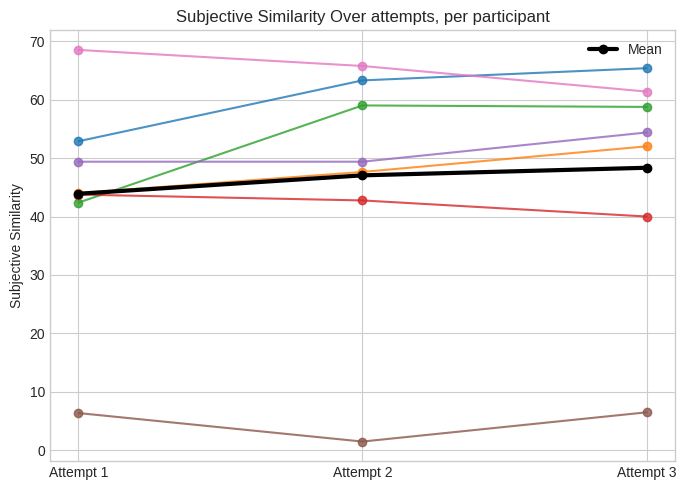

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set style for academic presentation
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

df_mean = df_ppt.groupby(["uid", "attempt"])["subjective_score"].mean().reset_index()
# Pivot to wide form
wide = df_mean.pivot(index="uid", columns="attempt", values="subjective_score")

plt.figure(figsize=(7,5))

# Pick a nice color palette (enough colors for all participants)
palette = sns.color_palette("tab10", n_colors=len(wide))

# Individual participant lines with unique colors
for (uid, row), color in zip(wide.iterrows(), palette):
    plt.plot([1,2,3], [row[1], row[2], row[3]], 
             marker="o", lw=1.5, alpha=0.8, color=color)

# Group mean in black
mean_vals = wide.mean()
plt.plot([1,2,3], mean_vals, marker="o", color="black", linewidth=3, label="Mean")

# Formatting
plt.xticks([1,2,3], ["Attempt 1", "Attempt 2", "Attempt 3"])
plt.ylabel("Subjective Similarity")
plt.title("Subjective Similarity Over attempts, per participant")
plt.legend()
plt.tight_layout()
plt.show()


## Now subjective similarity across images


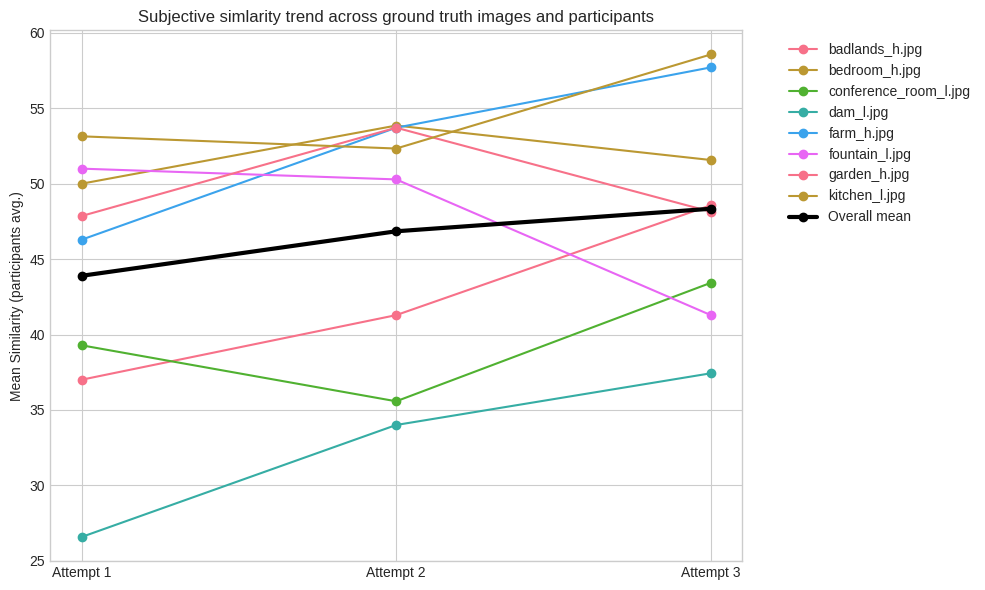

In [49]:
# 1) Mean subjective score per GT per attempt (averaging across participants)
df_gt = (
    df_ppt
    .groupby(["gt", "attempt"], as_index=False)["subjective_score"]
    .mean()
    .rename(columns={"subjective_score": "mean_score"})
)
plt.figure(figsize=(10,6))
for gt, sub in df_gt.groupby("gt"):
    plt.plot(sub["attempt"], sub["mean_score"], marker="o", lw=1.5, label=gt)

plt.plot(df_gt.groupby("attempt")["mean_score"].mean(), 
         marker="o", color="black", lw=3, label="Overall mean")

plt.xticks([1,2,3], ["Attempt 1","Attempt 2","Attempt 3"])
plt.ylabel("Mean Similarity (participants avg.)")
plt.title("Subjective simlarity trend across ground truth images and participants")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

## similarity scores per attempt - objective scoreres - ppt and gpt df


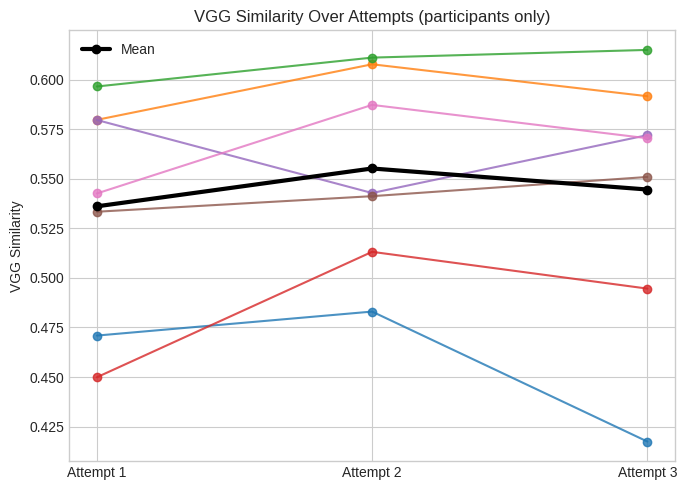

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set style for academic presentation
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

df_mean = df_ppt.groupby(["uid", "attempt"])["vgg_similarity"].mean().reset_index()
# Pivot to wide form
wide = df_mean.pivot(index="uid", columns="attempt", values="vgg_similarity")

plt.figure(figsize=(7,5))

# Pick a nice color palette (enough colors for all participants)
palette = sns.color_palette("tab10", n_colors=len(wide))

# Individual participant lines with unique colors
for (uid, row), color in zip(wide.iterrows(), palette):
    plt.plot([1,2,3], [row[1], row[2], row[3]], 
             marker="o", lw=1.5, alpha=0.8, color=color)

# Group mean in black
mean_vals = wide.mean()
plt.plot([1,2,3], mean_vals, marker="o", color="black", linewidth=3, label="Mean")

# Formatting
plt.xticks([1,2,3], ["Attempt 1", "Attempt 2", "Attempt 3"])
plt.ylabel("VGG Similarity")
plt.title("VGG Similarity Over Attempts (participants only)")
plt.legend()
plt.tight_layout()
plt.show()


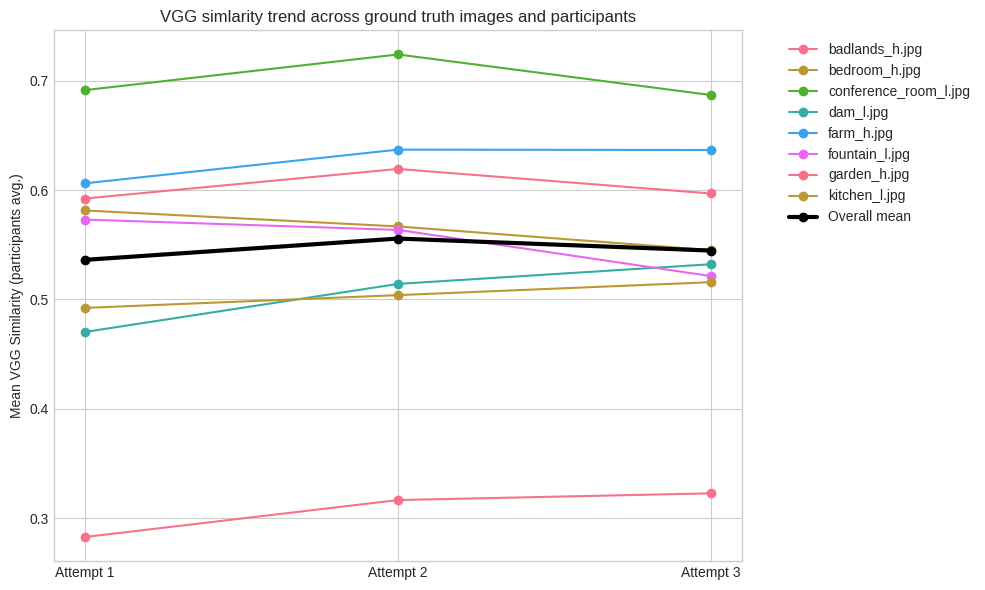

In [ ]:
# 1) Mean subjective score per GT per attempt (averaging across participants)
df_gt = (
    df_ppt
    .groupby(["gt", "attempt"], as_index=False)["vgg_similarity"]
    .mean()
    .rename(columns={"vgg_similarity": "mean_score"})
)
plt.figure(figsize=(10,6))
for gt, sub in df_gt.groupby("gt"):
    plt.plot(sub["attempt"], sub["mean_score"], marker="o", lw=1.5, label=gt)

plt.plot(df_gt.groupby("attempt")["mean_score"].mean(), 
         marker="o", color="black", lw=3, label="Overall mean")

plt.xticks([1,2,3], ["Attempt 1","Attempt 2","Attempt 3"])
plt.ylabel("Mean VGG Similarity (participants avg.)")
plt.title("VGG simlarity trend across ground truth images and participants (no gpt)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

## similarity scores per attemp - VGG and CLIP for participants and gpt - we can see gpt generated images produce a slightly higher similarity scores, but no trend of increased similarity as attempts progress

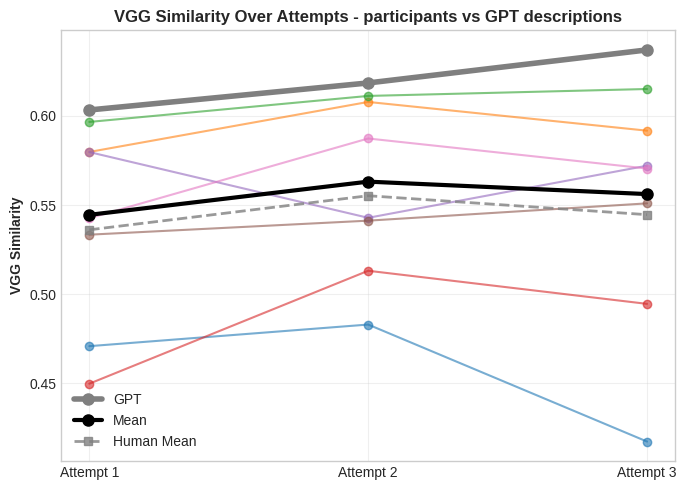

In [27]:
# Set style for academic presentation
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

df_mean = df.groupby(["uid", "attempt"])["vgg_similarity"].mean().reset_index()

# Pivot to wide form
wide = df_mean.pivot(index="uid", columns="attempt", values="vgg_similarity")

plt.figure(figsize=(7,5))

# Pick a nice color palette (enough colors for all participants)
palette = sns.color_palette("tab10", n_colors=len(wide))

# Individual participant lines with unique colors
for (uid, row), color in zip(wide.iterrows(), palette):
    if uid == 'gpt-5':  # Assuming GPT's uid is 'gpt' - adjust as needed
        plt.plot([1,2,3], [row[1], row[2], row[3]], 
                 marker="o", alpha=1.0, color=color, 
                 label="GPT", linewidth=4, markersize=8)
    else:
        plt.plot([1,2,3], [row[1], row[2], row[3]], 
                 marker="o", lw=1.5, alpha=0.6, color=color)

# Group mean in black
mean_vals = wide.mean()
plt.plot([1,2,3], mean_vals, marker="o", color="black", linewidth=3, 
         label="Mean", markersize=8)

# Add human average line (excluding GPT if needed)
human_data = wide[wide.index != 'gpt-5']  # Adjust GPT identifier as needed
human_mean = human_data.mean()
plt.plot([1,2,3], human_mean, marker="s", color="gray", linewidth=2, 
         linestyle="--", label="Human Mean", alpha=0.8, markersize=6)

# Formatting
plt.xticks([1,2,3], ["Attempt 1", "Attempt 2", "Attempt 3"])
plt.ylabel("VGG Similarity", fontweight='bold')
plt.title("VGG Similarity Over Attempts - participants vs GPT descriptions", fontweight='bold')
plt.legend(fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

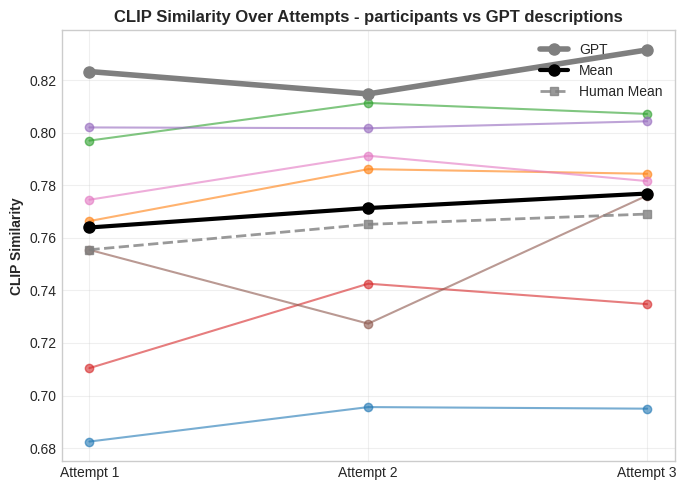

In [51]:
# Set style for academic presentation
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

df_mean = df.groupby(["uid", "attempt"])["clip_similarity"].mean().reset_index()

# Pivot to wide form
wide = df_mean.pivot(index="uid", columns="attempt", values="clip_similarity")

plt.figure(figsize=(7,5))

# Pick a nice color palette (enough colors for all participants)
palette = sns.color_palette("tab10", n_colors=len(wide))

# Individual participant lines with unique colors
for (uid, row), color in zip(wide.iterrows(), palette):
    if uid == 'gpt-5':  # Assuming GPT's uid is 'gpt' - adjust as needed
        plt.plot([1,2,3], [row[1], row[2], row[3]], 
                 marker="o", alpha=1.0, color=color, 
                 label="GPT", linewidth=4, markersize=8)
    else:
        plt.plot([1,2,3], [row[1], row[2], row[3]], 
                 marker="o", lw=1.5, alpha=0.6, color=color)

# Group mean in black
mean_vals = wide.mean()
plt.plot([1,2,3], mean_vals, marker="o", color="black", linewidth=3, 
         label="Mean", markersize=8)

# Add human average line (excluding GPT if needed)
human_data = wide[wide.index != 'gpt-5']  # Adjust GPT identifier as needed
human_mean = human_data.mean()
plt.plot([1,2,3], human_mean, marker="s", color="gray", linewidth=2, 
         linestyle="--", label="Human Mean", alpha=0.8, markersize=6)

# Formatting
plt.xticks([1,2,3], ["Attempt 1", "Attempt 2", "Attempt 3"])
plt.ylabel("CLIP Similarity", fontweight='bold')
plt.title("CLIP Similarity Over Attempts - participants vs GPT descriptions", fontweight='bold')
plt.legend(fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Comparing descriptions to gt images (without looking at gen images) - CLIP alignment between images and text (with 77 token limit)


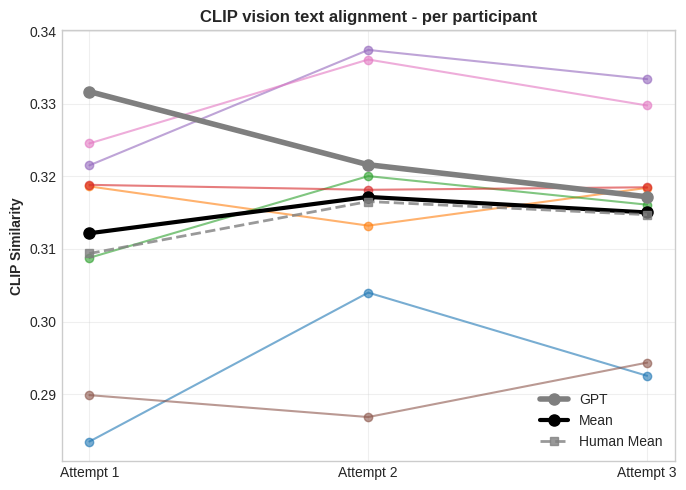

In [14]:
# Set style for academic presentation
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
# df_new_ppt = df_new[df_new['uid'] != 'gpt-5'].copy()
df_mean = df_new.groupby(["uid", "attempt"])["clip_vis_text_similarity"].mean().reset_index()

# Pivot to wide form
wide = df_mean.pivot(index="uid", columns="attempt", values="clip_vis_text_similarity")

plt.figure(figsize=(7,5))

# Pick a nice color palette (enough colors for all participants)
palette = sns.color_palette("tab10", n_colors=len(wide))

# Individual participant lines with unique colors
for (uid, row), color in zip(wide.iterrows(), palette):
    if uid == 'gpt-5':  # Assuming GPT's uid is 'gpt' - adjust as needed
        plt.plot([1,2,3], [row[1], row[2], row[3]], 
                 marker="o", alpha=1.0, color=color, 
                 label="GPT", linewidth=4, markersize=8)
    else:
        plt.plot([1,2,3], [row[1], row[2], row[3]], 
                 marker="o", lw=1.5, alpha=0.6, color=color)

# Group mean in black
mean_vals = wide.mean()
plt.plot([1,2,3], mean_vals, marker="o", color="black", linewidth=3, 
         label="Mean", markersize=8)

# Add human average line (excluding GPT if needed)
human_data = wide[wide.index != 'gpt-5']  # Adjust GPT identifier as needed
human_mean = human_data.mean()
plt.plot([1,2,3], human_mean, marker="s", color="gray", linewidth=2, 
         linestyle="--", label="Human Mean", alpha=0.8, markersize=6)

# Formatting
plt.xticks([1,2,3], ["Attempt 1", "Attempt 2", "Attempt 3"])
plt.ylabel("CLIP Similarity", fontweight='bold')
plt.title("CLIP vision text alignment - per participant", fontweight='bold')
plt.legend(fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
df_new_ppt['token_num'].mean(), df_new_ppt['token_num'].std()

(np.float64(46.77245508982036), np.float64(31.52808590071287))

In [15]:
df_new_gpt = df_new[df_new['uid'] == 'gpt-5'].copy()
df_new_gpt['token_num'].mean(), df_new_gpt['token_num'].std()

(np.float64(137.5), np.float64(34.849989083648715))